In [37]:
pip install tensorflow_text

   ---------------------------------------- 0.0/5.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.0 MB 991.0 kB/s eta 0:00:06
    --------------------------------------- 0.1/5.0 MB 653.6 kB/s eta 0:00:08
    --------------------------------------- 0.1/5.0 MB 573.4 kB/s eta 0:00:09
    --------------------------------------- 0.1/5.0 MB 599.1 kB/s eta 0:00:09
   - -------------------------------------- 0.1/5.0 MB 561.1 kB/s eta 0:00:09
   - -------------------------------------- 0.2/5.0 MB 619.5 kB/s eta 0:00:08
   - -------------------------------------- 0.2/5.0 MB 621.6 kB/s eta 0:00:08
   - -------------------------------------- 0.2/5.0 MB 600.7 kB/s eta 0:00:08
   -- ------------------------------------- 0.3/5.0 MB 630.5 kB/s eta 0:00:08
   -- ------------------------------------- 0.3/5.0 MB 611.3 kB/s eta 0:00:08
   -- ------------------------------------- 0.3/5.0 MB 614.4 kB/s eta 0:00:08
   -

In [39]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import tensorflow_text as text

In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.10.1
Eager mode:  True
Hub version:  0.16.1
GPU is available


In [4]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("train-sample.csv")
df.shape

(140272, 15)

In [5]:
df.head(5)

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
0,6046168,05/18/2011 14:14:05,543315,09/17/2010 10:15:06,1,2,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,NaN,NaN,NaN,NaN,NaN,open
1,4873911,02/02/2011 11:30:10,465076,10/03/2010 09:30:58,192,24,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,jaxp,NaN,NaN,NaN,open
2,3311559,07/22/2010 17:21:54,406143,07/22/2010 16:58:20,1,0,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,enums,NaN,NaN,NaN,open
3,9990413,04/03/2012 09:18:39,851755,07/19/2011 10:22:40,4,1,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,NaN,NaN,NaN,04/15/2012 21:12:48,too localized
4,10421966,05/02/2012 21:25:01,603588,02/04/2011 18:05:34,334,14,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,NaN,NaN,NaN,NaN,open


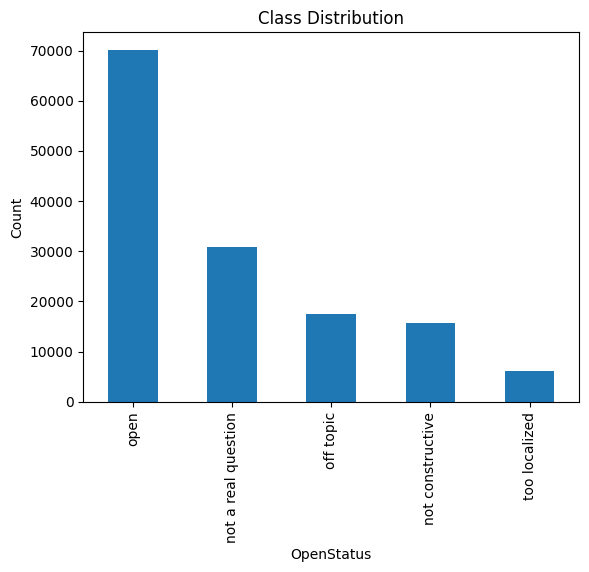

In [6]:
import matplotlib.pyplot as plt

df['OpenStatus'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('OpenStatus')
plt.ylabel('Count')
plt.show()

In [11]:
df.isnull().sum()

PostId                                      0
PostCreationDate                            0
OwnerUserId                                 0
OwnerCreationDate                           0
ReputationAtPostCreation                    0
OwnerUndeletedAnswerCountAtPostTime         0
Title                                       0
BodyMarkdown                                0
Tag1                                       10
Tag2                                    27251
Tag3                                    64358
Tag4                                   100622
Tag5                                   124558
PostClosedDate                          70136
OpenStatus                                  0
dtype: int64

In [14]:
from sklearn.model_selection import train_test_split


# Splitting the dataset into train, validation and test (80%, 10% and 10% respectively)
train_df, remaining = train_test_split(df, random_state=42, train_size=0.8, stratify=df.OpenStatus.values)
valid_df, test_df = train_test_split(remaining, random_state=42, train_size=0.50, stratify=remaining.OpenStatus.values)



# Display the shapes of the downsampled training and validation datasets
train_df.shape, valid_df.shape, test_df.shape

((112217, 15), (14027, 15), (14028, 15))

In [15]:
class_distribution = train_df['OpenStatus'].value_counts()
print(class_distribution)

OpenStatus
open                   56109
not a real question    24631
off topic              14024
not constructive       12527
too localized           4926
Name: count, dtype: int64


In [16]:
from sklearn.utils import resample

# Separating different classes in the dataset
open_class = train_df[train_df.OpenStatus == 'open']
not_a_real_question_class = train_df[train_df.OpenStatus == 'not a real question']
off_topic_class = train_df[train_df.OpenStatus == 'off topic']
not_constructive_class = train_df[train_df.OpenStatus == 'not constructive']
too_localized_class = train_df[train_df.OpenStatus == 'too localized']


# Downsampling the 5 classes to the size of the 'off topic' class
open_class = resample(open_class,
                      replace=False,  # sample without replacement
                      n_samples=len(too_localized_class),  # match target class size
                      random_state=42)  # for reproducible results

not_a_real_question_class = resample(not_a_real_question_class,
                                     replace=False,  # sample without replacement
                                     n_samples=len(too_localized_class),  # match target class size
                                     random_state=42)  # for reproducible results

off_topic_class = resample(off_topic_class,
                                     replace=False,  # sample without replacement
                                     n_samples=len(too_localized_class),  # match target class size
                                     random_state=42)  # for reproducible results

not_constructive_class = resample(not_constructive_class,
                                     replace=False,  # sample without replacement
                                     n_samples=len(too_localized_class),  # match target class size
                                     random_state=42)  # for reproducible results

# Combining all the minority class with the resampled classes
train_df = pd.concat([open_class, 
                not_a_real_question_class, 
                off_topic_class, 
                not_constructive_class, 
                too_localized_class])

# Shuffle the downsampled training dataset
train_df = train_df.sample(frac=1, random_state=42)

In [17]:
# Checking the number of samples from each class of train_df

class_distribution = train_df['OpenStatus'].value_counts()
print(class_distribution)

OpenStatus
too localized          4926
off topic              4926
not a real question    4926
not constructive       4926
open                   4926
Name: count, dtype: int64


In [18]:
selected_columns = ['Title', 'BodyMarkdown', 'OpenStatus', 'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5']
train_df = train_df[selected_columns]
valid_df = valid_df[selected_columns]
test_df = test_df[selected_columns]

In [19]:
train_df.head(5)

,Title,BodyMarkdown,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5
129910,"My application works on all browsers, but in I...",this is the application I developed: games.our...,too localized,jquery,internet-explorer,NaN,NaN,NaN
85448,how can I become an image creator?,I'm a web developer but I usually have difficu...,off topic,image,design,drawing,logo,beautytips
102045,how create a box like this in css3,Images link is\r\nhttp://imageshack.us/photo/m...,not a real question,html,css,NaN,NaN,NaN
79606,What's the next big thing after LINQ?,I started using LINQ (Language Integrated Quer...,not constructive,linq,plinq,c#,language-features,future
103309,Java - Help with parsing file into arrayList,I need another set of eyes to tell me a better...,not a real question,java,io,NaN,NaN,NaN


In [25]:
for index, row in train_df.iterrows():
    text = "Title: " + "'" + row.Title + "'" 
    text += "  Body: " + "'" + row.BodyMarkdown + "'"
    train_df.at[index, 'text'] = text
    

for index, row in valid_df.iterrows():
    text = "Title: " + "'" + row.Title + "'" 
    text += "  Body: " + "'" + row.BodyMarkdown + "'"
    valid_df.at[index, 'text'] = text

for index, row in test_df.iterrows():
    text = "Title: " + "'" + row.Title + "'" 
    text += "  Body: " + "'" + row.BodyMarkdown + "'"
    test_df.at[index, 'text'] = text

In [28]:
train_df['text'].values

array(["Title: 'My application works on all browsers, but in IE doesn't work, it works in debug mode in IE only,'  Body: 'this is the application I developed: games.ourcity-sy.com\r\n\r\nin IE(I tried 9 and 8)  and  it doesn't work well in the normal mode, but when I get to debug mode F12, it works with some problems,\r\n\r\nwhat could be the solution??'",
       "Title: 'how can I become an image creator?'  Body: 'I'm a web developer but I usually have difficulties making my apps beautiful. I need to learn how to create good images, icons, backgrounds, logos, etc.\r\n\r\nthe problem is, I don't know for sure where do I start. I need guidance. can you guys show me a pathway to learn that kind of stuff from zero to expert? what do I have to read? what do I have to learn first? what programs should I use to draw? thank you (:\r\n\r\nps: i was afraid of asking it here because it's not a programming issue, but i guess it fits the FAQ category `software tools commonly used by programmers`. 

In [29]:
columns_to_drop = ['Title', 'BodyMarkdown']
train_df.drop(columns=columns_to_drop, inplace=True)
valid_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

In [31]:
train_df.head(5)

,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5,text
129910,too localized,jquery,internet-explorer,NaN,NaN,NaN,"Title: 'My application works on all browsers, ..."
85448,off topic,image,design,drawing,logo,beautytips,Title: 'how can I become an image creator?' B...
102045,not a real question,html,css,NaN,NaN,NaN,Title: 'how create a box like this in css3' B...
79606,not constructive,linq,plinq,c#,language-features,future,Title: 'What's the next big thing after LINQ?'...
103309,not a real question,java,io,NaN,NaN,NaN,Title: 'Java - Help with parsing file into arr...


In [32]:
# Definelabel mapping
custom_label_mapping = {'open': 0, 
                        'not a real question': 1, 
                        'off topic': 2,
                        'not constructive': 3, 
                        'too localized': 4
                       }  

# Initialize LabelEncoder with custom mapping
encoded_labels = []
for index, row in train_df.iterrows():
    label = row['OpenStatus']
    encoded_label = custom_label_mapping[label]
    encoded_labels.append(encoded_label)

# Add the encoded labels as a new column in the DataFrame
train_df['OpenStatus_encoded'] = encoded_labels



# Applying the same changes to valid_df and test_df

encoded_labels = []
for index, row in valid_df.iterrows():
    label = row['OpenStatus']
    encoded_label = custom_label_mapping[label]
    encoded_labels.append(encoded_label)

# Add the encoded labels as a new column in the DataFrame
valid_df['OpenStatus_encoded'] = encoded_labels



encoded_labels = []
for index, row in test_df.iterrows():
    label = row['OpenStatus']
    encoded_label = custom_label_mapping[label]
    encoded_labels.append(encoded_label)

# Add the encoded labels as a new column in the DataFrame
test_df['OpenStatus_encoded'] = encoded_labels

In [33]:
train_df.tail(5)

,OpenStatus,Tag1,Tag2,Tag3,Tag4,Tag5,text,OpenStatus_encoded
136603,too localized,mybatis,struts1,NaN,NaN,NaN,Title: 'cant find org/apache/ibatis/io/Resourc...,4
14150,not a real question,php,frameworks,content-management-system,NaN,NaN,Title: 'PHP-Framework or CMS .. ?' Body: 'I w...,1
109104,open,c#,NaN,NaN,NaN,NaN,Title: 'Looking for Locations API (c#)' Body:...,0
135635,not constructive,silverlight-4.0,NaN,NaN,NaN,NaN,Title: 'Simple Silverlight Examples' Body: 'I...,3
73465,too localized,php,joomla2.5,stdclass,NaN,NaN,Title: 'Call to undefined method stdClass::onD...,4


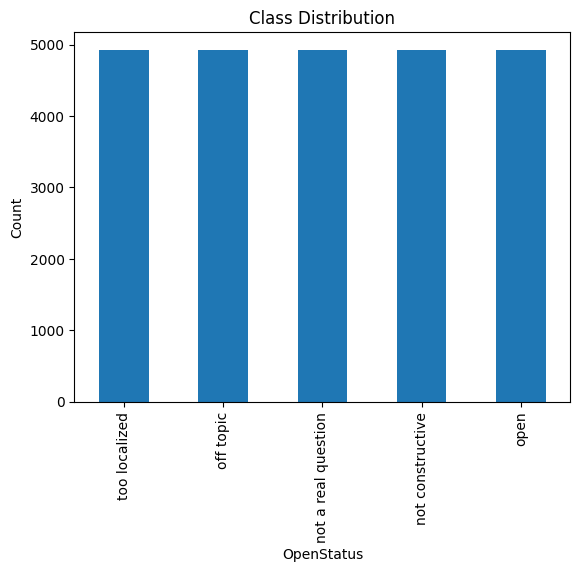

In [34]:
train_df['OpenStatus'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('OpenStatus')
plt.ylabel('Count')
plt.show()

In [35]:
X_train = train_df["text"]
y_train = train_df["OpenStatus_encoded"]

X_valid = valid_df["text"]
y_valid = valid_df["OpenStatus_encoded"]

X_test = test_df["text"]
y_test = test_df["OpenStatus_encoded"]

### Using BERT

In [42]:
preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
# Tokenize the input text
input_text = ["I am making a Speech and Language Processing Project"]
tokenized_output = preprocessor(input_text)

# Print token IDs
print(tokenized_output['input_word_ids'])

tf.Tensor(
[[ 101 1045 2572 2437 1037 4613 1998 2653 6364 2622  102    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]], shape=(1, 128), dtype=int32)


### Model Building 

In [43]:
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string)
encoder_inputs = preprocessor(text_input)

In [44]:
encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2",trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [45]:
# Classification
# Add dropout layer
drop1 = tf.keras.layers.Dropout(0.5)(pooled_output)
batch_norm1 = tf.keras.layers.BatchNormalization()(drop1)

# Add hidden dense layers
hidden1 = tf.keras.layers.Dense(512, activation='relu')(batch_norm1)
drop2 = tf.keras.layers.Dropout(0.4)(hidden1)
batch_norm2 = tf.keras.layers.BatchNormalization()(drop2)
hidden2 = tf.keras.layers.Dense(128, activation='relu')(batch_norm2)
drop3 = tf.keras.layers.Dropout(0.3)(hidden2)
batch_norm3 = tf.keras.layers.BatchNormalization()(drop3)
hidden3 = tf.keras.layers.Dense(32, activation='relu')(batch_norm3)
drop4 = tf.keras.layers.Dropout(0.2)(hidden3)
batch_norm4 = tf.keras.layers.BatchNormalization()(drop4)

# Output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output')(batch_norm4)


model=tf.keras.Model(inputs=[text_input],outputs=[output_layer])

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [47]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',  # Path to save the best model
        save_best_only=True,  # Save only the best model
        monitor='val_accuracy',  # Quantity to be monitored
        save_weights_only=True,  # Do not save the entire model
        verbose=1,  # Verbosity mode. 0 or 1.
        save_freq='epoch'  # Save the model at the end of every epoch
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        monitor='val_accuracy',  # Quantity to be monitored
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  # Quantity to be monitored
        factor=0.5,  # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-10  # Lower bound on the learning rate
    )
]

In [55]:
# Train model
epochs = 10
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_valid, y_valid),
                    batch_size=1,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks
                   )

Epoch 1/10
 1154/24630 [>.............................] - ETA: 39:03 - loss: 1.6095 - accuracy: 0.2019

KeyboardInterrupt: 